In [3]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *


In [4]:
#224x224 

In [31]:
BATCH_SIZE=64
IMAGE_SIZE=(128,128)
train_loader,val_loader=create_dataloader(IMAGE_SIZE,batch_size=BATCH_SIZE,data_precentage=1)
val_dataset = val_loader.dataset
print(val_dataset[0][0].shape)


# Get the datasets
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

# Print the size of the datasets
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

AttributeError: 'tuple' object has no attribute 'shape'

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten the tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice


dice_loss = DiceLoss()

In [14]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
# Function to count the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
num_params = count_parameters(model)
print(f"Number of parameters in the model: {num_params}")


Number of parameters in the model: 7763041


Using cache found in /Users/anton_heden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [15]:
# from time import time
# import multiprocessing as mp

# for num_workers in tqdm(range(2, mp.cpu_count(), 2)):  
#     train_loader = DataLoader(train_dataset, shuffle=True, num_workers=num_workers, batch_size=32, pin_memory=True)

#     start = time()  # Start the timer here
#     for epoch in range(1, 3):
#         for i, data in enumerate(train_loader, 0):
#             pass  # Simulate the training loop
#     end = time()  # End the timer after the training loop finishes

#     print(f"Finish with: {end - start:.2f} seconds, num_workers={num_workers}")

In [9]:

# Freeze all layers
for param in model.parameters():
    param.requires_grad = True

# Unfreeze specific layers (e.g., the last decoder layer)
# Unfreeze specific layers (e.g., the last decoder layer)
for param in model.decoder4.parameters():
    param.requires_grad = True
for param in model.decoder3.parameters():
    param.requires_grad = True
for param in model.decoder2.parameters():
    param.requires_grad = True
for param in model.decoder1.parameters():
    param.requires_grad = True

In [16]:

# Function to count the number of trainable parameters in the model
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters in the model
num_trainable_params = count_trainable_parameters(model)
print(f"Number of trainable parameters in the model: {num_trainable_params}")

Number of trainable parameters in the model: 7763041


In [17]:
import torch
import train 
importlib.reload(train)
from train import training_loop
import time


# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005, weight_decay=1e-4)
#
loss_fn= DiceLoss()
star_time=time.time()
unet_metrics=training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=10,warmup_epochs=3)
end_time=time.time()    

print(f"Training time: {end_time-star_time}s")

Starting training
Training on device mps


100%|██████████| 24/24 [01:12<00:00,  3.01s/it]


Epoch 1/10: Train loss: 0.520, Train f1.: 0.481, Train accuracy: 0.948, Val. loss: 0.406, Val. f1.: 0.595 Val. accuracy: 0.963


100%|██████████| 24/24 [01:07<00:00,  2.83s/it]


Epoch 2/10: Train loss: 0.396, Train f1.: 0.605, Train accuracy: 0.966, Val. loss: 0.618, Val. f1.: 0.383 Val. accuracy: 0.917


100%|██████████| 24/24 [01:10<00:00,  2.92s/it]


Epoch 3/10: Train loss: 0.410, Train f1.: 0.590, Train accuracy: 0.966, Val. loss: 0.883, Val. f1.: 0.117 Val. accuracy: 0.379


100%|██████████| 24/24 [01:08<00:00,  2.84s/it]


Epoch 4/10: Train loss: 0.367, Train f1.: 0.634, Train accuracy: 0.969, Val. loss: 0.508, Val. f1.: 0.492 Val. accuracy: 0.969


100%|██████████| 24/24 [01:06<00:00,  2.78s/it]


Epoch 5/10: Train loss: 0.323, Train f1.: 0.678, Train accuracy: 0.973, Val. loss: 0.381, Val. f1.: 0.619 Val. accuracy: 0.961


100%|██████████| 24/24 [01:06<00:00,  2.75s/it]


Epoch 6/10: Train loss: 0.308, Train f1.: 0.692, Train accuracy: 0.974, Val. loss: 0.397, Val. f1.: 0.604 Val. accuracy: 0.970


100%|██████████| 24/24 [01:06<00:00,  2.77s/it]


Epoch 7/10: Train loss: 0.284, Train f1.: 0.716, Train accuracy: 0.977, Val. loss: 0.340, Val. f1.: 0.660 Val. accuracy: 0.975


100%|██████████| 24/24 [01:06<00:00,  2.79s/it]


Epoch 8/10: Train loss: 0.271, Train f1.: 0.729, Train accuracy: 0.978, Val. loss: 0.419, Val. f1.: 0.582 Val. accuracy: 0.974


100%|██████████| 24/24 [01:09<00:00,  2.88s/it]


Epoch 9/10: Train loss: 0.268, Train f1.: 0.733, Train accuracy: 0.978, Val. loss: 0.370, Val. f1.: 0.631 Val. accuracy: 0.969
Early stopping
Training time: 736.7405071258545s


In [56]:
import torch
import torch.nn as nn
import importlib
import train 
importlib.reload(train)
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *
from train import training_loop

# Define a modified U-Net model with an additional fully connected layer
class ModifiedUNet(nn.Module):
    def __init__(self, original_unet,img_size):
        super(ModifiedUNet, self).__init__()
        self.unet = original_unet
        #self.fc = nn.Linear(img_size[0] * img_size[1] * 1, 4)  # Assuming the final feature map size is 32x32 with 1 channel
        self.fc = nn.Linear(32 * (img_size[0] // 32) * (img_size[1] // 32), 4)  # Adjust based on the final feature map size

    def forward(self, x):
        x = self.unet(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Pool to 1x1
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc(x)  # Fully connected layer to produce 4x1 output
        return x

# Load the pre-trained U-Net model
#original_unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#    in_channels=3, out_channels=1, init_features=32, pretrained=True)


train_loader2,val_loader2=create_dataloader(IMAGE_SIZE,batch_size=BATCH_SIZE,bbox_out=True,data_precentage=1)

# Create an instance of the modified U-Net model
model = ModifiedUNet(model,IMAGE_SIZE)

# Freeze all layers except the new fully connected layer
for param in model.unet.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005, weight_decay=1e-4)
regression_loss_fn = nn.MSELoss()
# Measure the training time
unet_metrics = training_loop(model, optimizer, loss_fn, train_loader2, val_loader2, num_epochs=10, warmup_epochs=3)



Starting training
Training on device mps


  0%|          | 0/24 [00:01<?, ?it/s]

torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x1 and 16384x4)

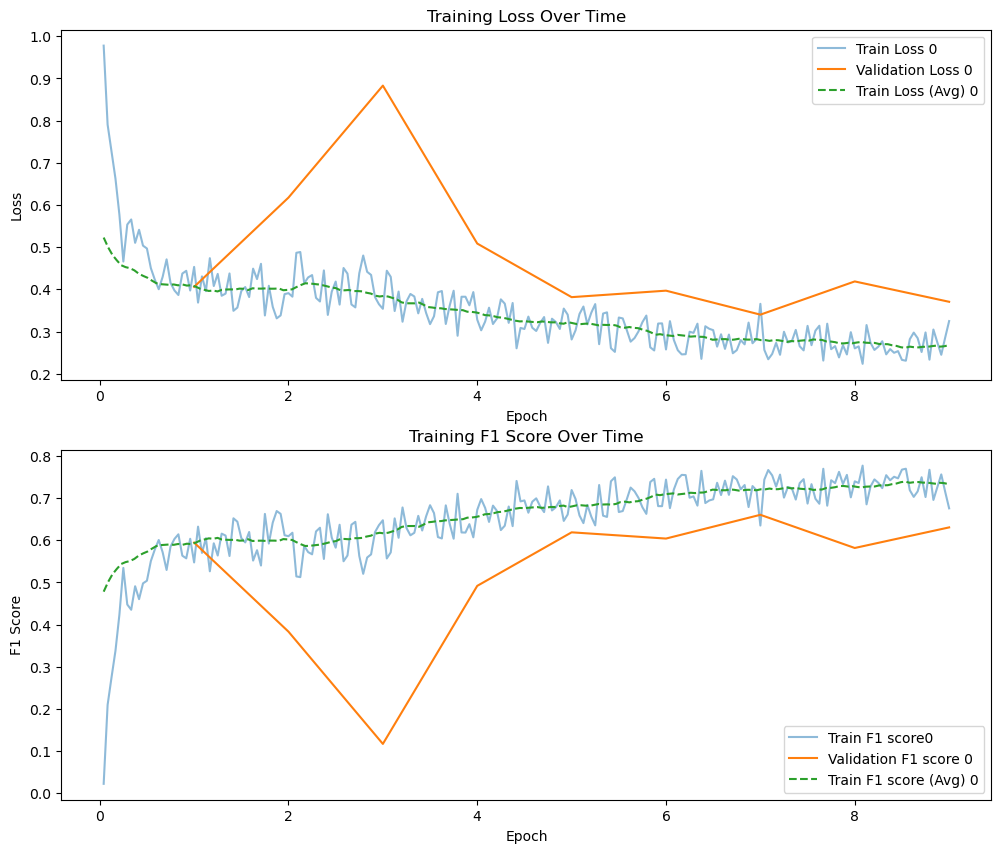

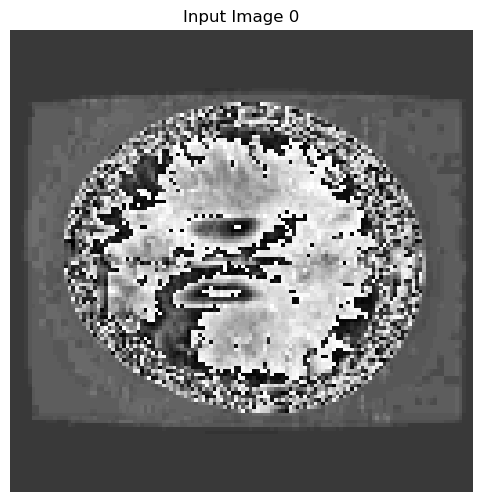

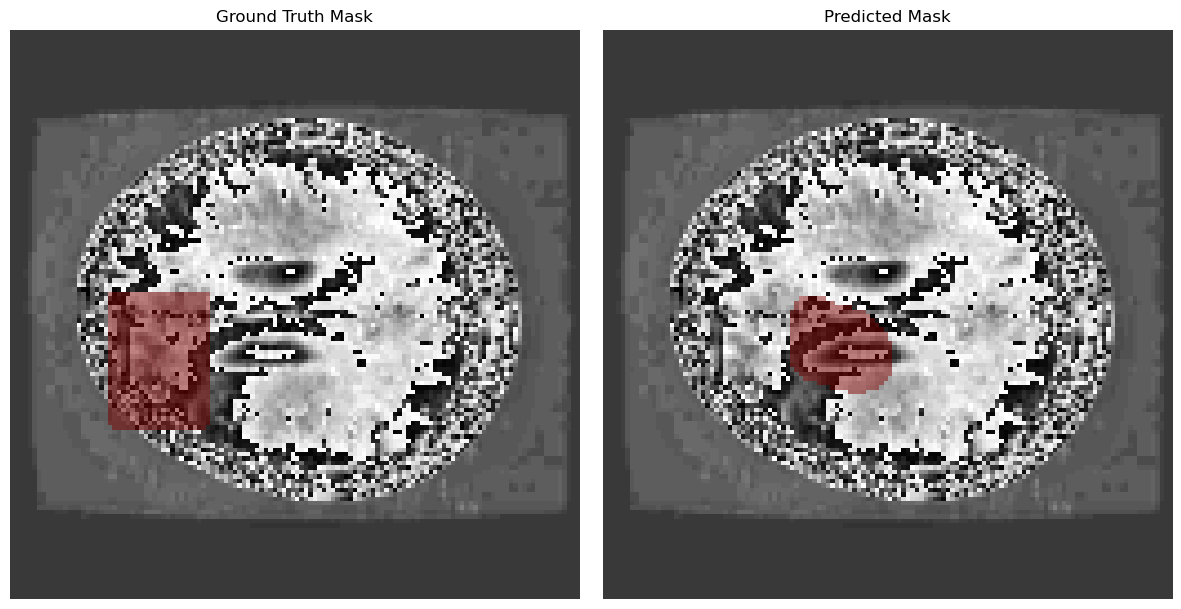

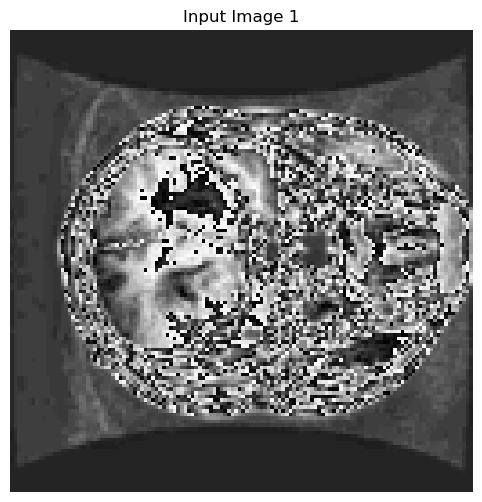

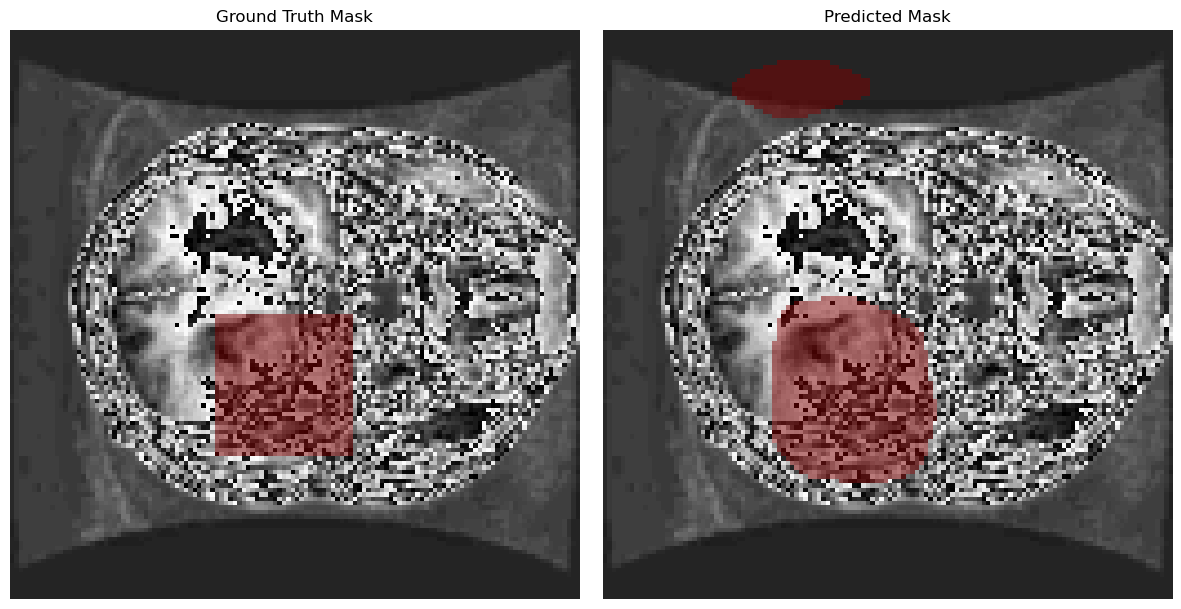

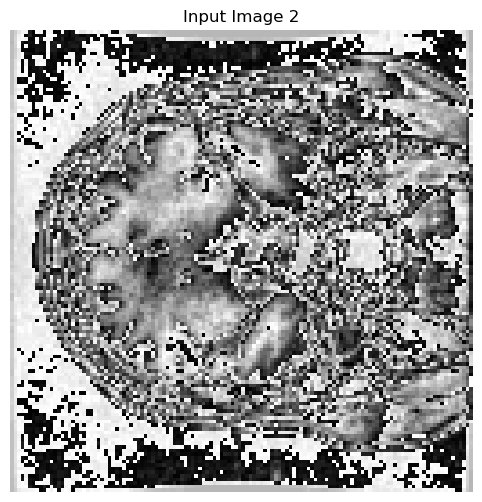

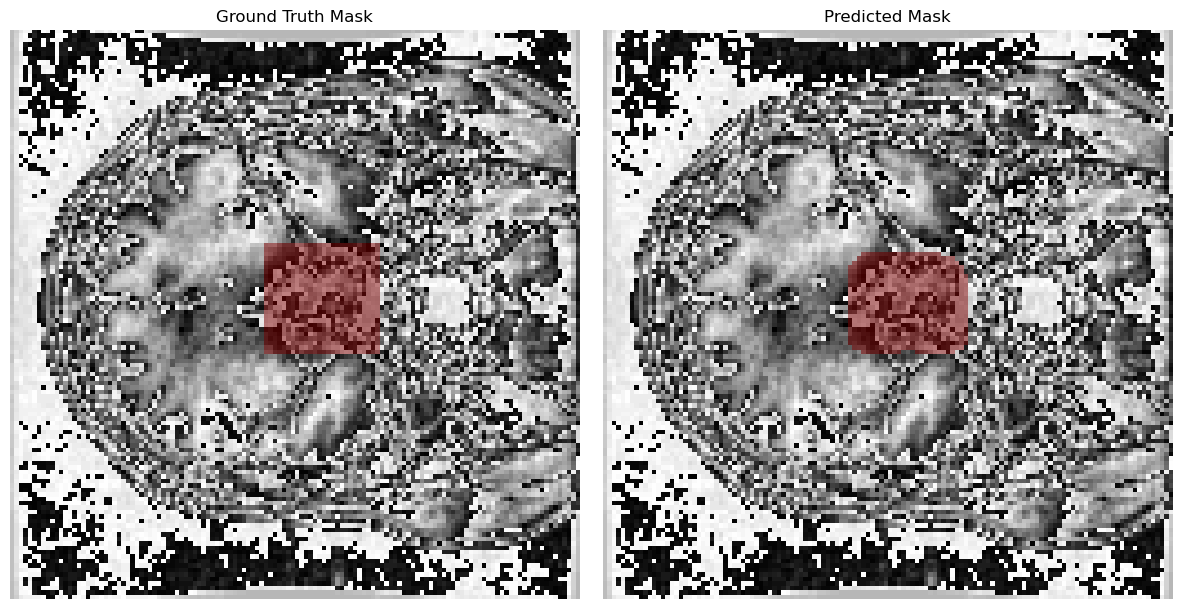

In [18]:
import visualisation
importlib.reload(visualisation)
from visualisation import *


plot_performance_metrics([unet_metrics],batch_size=BATCH_SIZE)
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([0,1,2], val_dataset, unet_metrics[0])

In [91]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
import numpy as np

# Load the model and performance metrics
trained_metrics = get_model_and_performance_metrics("unet_brain2_seg_640.pth", model)
#plot_performance_metrics([trained_metrics],batch_size=16)

# Get the validation dataset
val_dataset = val_loader.dataset


# Plot comparison for a specific index
#Crea list from 20 to 50


plot_comparison([74], val_dataset, model)

ModuleNotFoundError: No module named 'numpy._core'

In [89]:
import train
import preprocessing
importlib.reload(train)
importlib.reload(preprocessing)
from train import predict_and_calc_f1
from preprocessing import *
trained_metrics = get_model_and_performance_metrics("unet_brain2_seg.pth", model)

#model
#model=trained_metrics[0]

# Load COCO annotations for training and validation sets
test_json_path = 'test/_annotations.coco.json'
test_img_dir = 'test'

train_images, train_annotations, train_categories = load_coco_annotations(test_json_path)



test_dataset = BrainData(train_images, train_annotations, test_img_dir, IMAGE_SIZE) 
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)



device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
# Move the model to the appropriate device
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

#print(predict_and_calc_f1(model, test_dataloader,device))
f1_scores,accs_score,predictions,area_diff=predict_and_calc_f1(model, test_dataloader,device)
print(np.mean(accs_score))
print(np.mean(f1_scores))


100%|██████████| 215/215 [01:58<00:00,  1.82it/s]

0.9350597860646803
0.1400535524347565


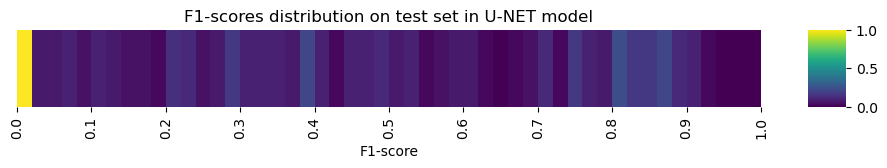

In [84]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to represent the density of numbers
hist, bins = np.histogram(f1_scores, bins=50, range=(0, 1))

# Normalize the histogram
hist = hist / hist.max()

# Create a 2D array for the heatmap
heatmap_data = np.tile(hist, (10, 1))

# Create the plot
plt.figure(figsize=(12, 1))  # Wide and low in height
num_ticks = 11
tick_positions = np.linspace(0, heatmap_data.shape[1], num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)


sns.heatmap(heatmap_data, cmap='viridis', cbar=True, xticklabels=True, yticklabels=False,cbar_kws={"shrink": 1, "aspect": 2})
plt.xticks(tick_positions, [f"{label:.1f}" for label in tick_labels])

plt.title('F1-scores distribution on test set in U-NET model')
plt.xlabel('F1-score')
#plt.ylabel('Intensity')
plt.show()

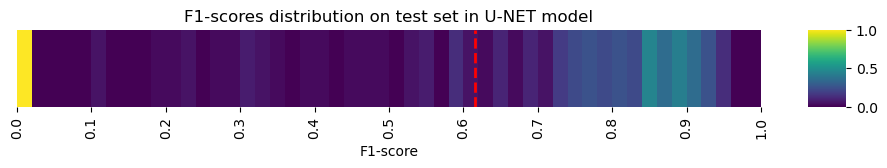

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
#f1_scores = np.random.rand(1000)

# Create a histogram to represent the density of numbers
hist, bins = np.histogram(f1_scores, bins=50, range=(0, 1))

# Normalize the histogram
hist = hist / hist.max()

# Create a 2D array for the heatmap
heatmap_data = np.tile(hist, (10, 1))

# Calculate the mean of the f1_scores
mean_value = np.mean(f1_scores)

# Create the plot
plt.figure(figsize=(12, 1))  # Wide and low in height
num_ticks = 11
tick_positions = np.linspace(0, heatmap_data.shape[1], num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)

sns.heatmap(heatmap_data, cmap='viridis', cbar=True, xticklabels=True, yticklabels=False, cbar_kws={"shrink": 1, "aspect": 2})
plt.xticks(tick_positions, [f"{label:.1f}" for label in tick_labels])

# Add a red line at the mean value
plt.axvline(x=mean_value * heatmap_data.shape[1], color='red', linestyle='--', linewidth=2)

plt.title('F1-scores distribution on test set in U-NET model')
plt.xlabel('F1-score')
#plt.ylabel('Intensity')
plt.show()